In [ ]:
pip install elephas

In [ ]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]')
sc = SparkContext(conf=conf)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame

from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime  
import cv2 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
%matplotlib inline

In [ ]:


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
from imutils import paths
import os
import time
from keras.preprocessing.image import img_to_array

data=[]
labels=[]
i=1
d=[]

imagePaths = sorted(list(paths.list_images("/content/drive/MyDrive/chest_xray/train")))
for imagePath in imagePaths:
  print(i)
  i+=1
  image = cv2.imread(imagePath)
  image = cv2.resize(image,(50, 50))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = img_to_array(image)
  label = imagePath.split(os.path.sep)[-2]
  if label=="NORMAL":
    label=1
    d.append((image,label))
    data.append(image)
    labels.append(label)
  elif label=="PNEUMONIA":
    label=0
    data.append(image)
    d.append((image,label))
    labels.append(label)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
import random
random.shuffle(d)

In [ ]:
data=[]
labels=[]
for i in d:
  data.append(i[0])
  labels.append(i[1])

In [ ]:
import numpy as np
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

train_X = data
train_y = labels
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(data)*VAL_PCT)
print(val_size)

train_X = data[:-val_size]
train_y = labels[:-val_size]

test_X = data[-val_size:]
test_y = labels[-val_size:]

393


In [ ]:
print(len(train_X),len(test_X))
d=0
n=0
for i in range(len(train_y)):
  if train_y[i]==1:
    n+=1
  else:
    d+=1
print(d,n)

3542 393
3464 78


In [ ]:
EPOCHS = 30
BATCH_SIZE = 16
steps_per_epoch = len(train_X)//BATCH_SIZE
print("Steps per epoch: ", steps_per_epoch)  

Steps per epoch:  221


In [ ]:
import tensorflow as tf

In [ ]:
 model = tf.keras.Sequential(
      [
        
        tf.keras.layers.Conv2D(32, (5, 5), input_shape = (50, 50, 1), activation = 'relu'), # no bias necessary before batch norm
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        
        tf.keras.layers.Conv2D(64, (5, 5), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
        
        tf.keras.layers.Conv2D(128, (5, 5), activation = 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 512, activation = 'relu'),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
      ])


In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

from elephas.ml_model import ElephasEstimator
from elephas.ml.adapter import to_data_frame

from pyspark import SparkContext, SparkConf
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline





batch size 16

In [ ]:
start_time=time.time()
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd
sgd = SGD(lr=0.1)
model.compile(sgd, 'categorical_crossentropy', ['acc'])

# Build RDD from numpy features and labels
rdd = to_simple_rdd(sc,train_X, train_y)

# Initialize SparkModel from tensorflow.keras model and Spark context
spark_model = SparkModel(model, mode='asynchronous')

# Train Spark model
spark_model.fit(rdd, epochs=30, batch_size=16, verbose=2, validation_split=0.1)

# Evaluate Spark model by evaluating the underlying model
score = spark_model.evaluate(test_X, test_y, verbose=2)
print('Test accuracy:', score[1])
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


>>> Fit model
 * Serving Flask app "elephas.parameter.server" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://172.28.0.2:4000/ (Press CTRL+C to quit)


>>> Initialize workers
>>> Distribute load


172.28.0.2 - - [17/Mar/2022 11:11:03] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:03] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:03] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:03] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:03] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:03] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:03] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:04] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:28] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:28] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:28] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:28] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:28] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:11:28] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - 

>>> Async training complete.
Test accuracy: 0.9847449064254761
--- 629.8191955089569 seconds ---


In [ ]:
start_time=time.time()
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd
sgd = SGD(lr=0.1)
model.compile(sgd, 'categorical_crossentropy', ['acc'])

# Build RDD from numpy features and labels
rdd = to_simple_rdd(sc,train_X, train_y)

# Initialize SparkModel from tensorflow.keras model and Spark context
spark_model = SparkModel(model, mode='synchronous')

# Train Spark model
spark_model.fit(rdd, epochs=30, batch_size=16, verbose=2, validation_split=0.1)

# Evaluate Spark model by evaluating the underlying model
score = spark_model.evaluate(test_X, test_y, verbose=2)
print('Test accuracy:', score[1])
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


>>> Fit model
>>> Synchronous training complete.
Test accuracy: 0.9847449064254761
--- 579.7015821933746 seconds ---


In [ ]:
from tensorflow.keras.callbacks import *
start_time=time.time()
sgd = SGD(lr=0.1)
model.compile(sgd, 'categorical_crossentropy', ['acc'])
model.fit(train_X,train_y, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,validation_data=(test_X,test_y),batch_size=BATCH_SIZE)
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
221/221 [==============================] - 24s 107ms/step - loss: nan - acc: 0.9779 - val_loss: nan - val_acc: 0.9847
Epoch 2/30
221/221 [==============================] - 25s 114ms/step - loss: nan - acc: 0.9779 - val_loss: nan - val_acc: 0.9847
Epoch 3/30
221/221 [==============================] - 23s 105ms/step - loss: nan - acc: 0.9782 - val_loss: nan - val_acc: 0.9847
Epoch 4/30
221/221 [==============================] - 24s 106ms/step - loss: nan - acc: 0.9776 - val_loss: nan - val_acc: 0.9847
Epoch 5/30
221/221 [==============================] - 23s 106ms/step - loss: nan - acc: 0.9784 - val_loss: nan - val_acc: 0.9847
Epoch 6/30
221/221 [==============================] - 23s 106ms/step - loss: nan - acc: 0.9776 - val_loss: nan - val_acc: 0.9847
Epoch 7/30
221/221 [==============================] - 23s 104ms/step - loss: nan - acc: 0.9782 - val_loss: nan - val_acc: 0.9847
Epoch 8/30
221/221 [==============================] - 23s 104ms/step - loss: nan - acc: 0.9773 - 

In [ ]:
score = model.evaluate(test_X, test_y, verbose=2)
print('Test accuracy:', score[1])

13/13 - 1s - loss: nan - acc: 0.9847 - 618ms/epoch - 48ms/step
Test accuracy: 0.9847328066825867


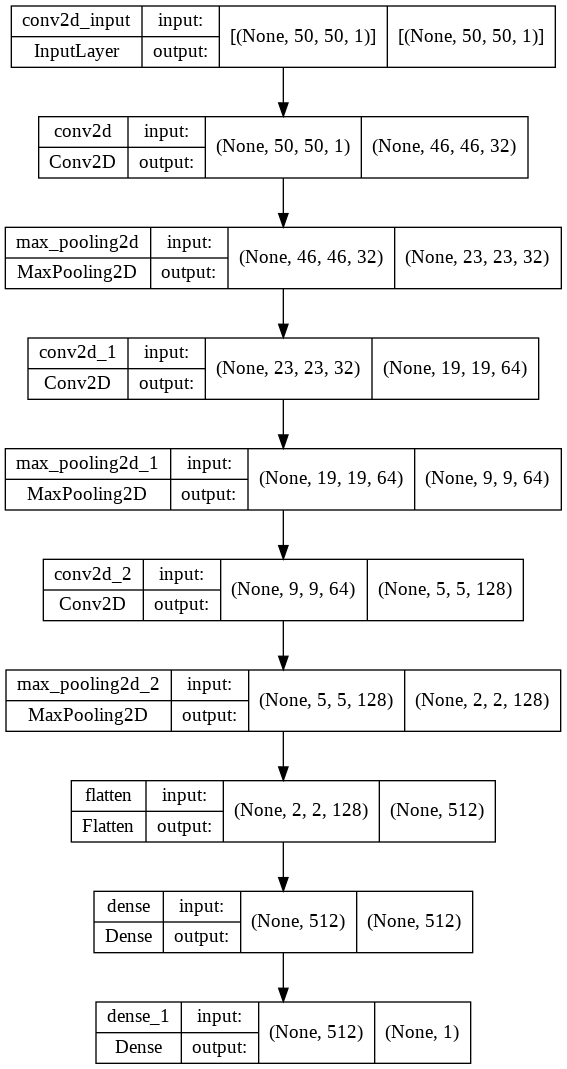

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model,  show_shapes=True, show_layer_names=True)

batch size 32 

In [ ]:
start_time=time.time()
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd
sgd = SGD(lr=0.1)
model.compile(sgd, 'categorical_crossentropy', ['acc'])

# Build RDD from numpy features and labels
rdd = to_simple_rdd(sc,train_X, train_y)

# Initialize SparkModel from tensorflow.keras model and Spark context
spark_model = SparkModel(model, mode='asynchronous')

# Train Spark model
spark_model.fit(rdd, epochs=30, batch_size=32, verbose=2, validation_split=0.1)

# Evaluate Spark model by evaluating the underlying model
score = spark_model.evaluate(test_X, test_y, verbose=2)
print('Test accuracy:', score[1])
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


>>> Fit model
 * Serving Flask app "elephas.parameter.server" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://172.28.0.2:4000/ (Press CTRL+C to quit)


>>> Initialize workers
>>> Distribute load


172.28.0.2 - - [17/Mar/2022 11:50:10] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:10] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:10] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:10] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:10] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:11] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:11] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:11] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:35] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:35] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:35] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:35] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:35] "POST /update HTTP/1.1" 200 -
172.28.0.2 - - [17/Mar/2022 11:50:36] "GET /parameters HTTP/1.1" 200 -
172.28.0.2 - - 

>>> Async training complete.
Test accuracy: 0.9847449064254761
--- 613.6063942909241 seconds ---


In [ ]:
start_time=time.time()
from elephas.spark_model import SparkModel
from elephas.utils.rdd_utils import to_simple_rdd
sgd = SGD(lr=0.1)
model.compile(sgd, 'categorical_crossentropy', ['acc'])

# Build RDD from numpy features and labels
rdd = to_simple_rdd(sc,train_X, train_y)

# Initialize SparkModel from tensorflow.keras model and Spark context
spark_model = SparkModel(model, mode='synchronous')

# Train Spark model
spark_model.fit(rdd, epochs=30, batch_size=32, verbose=2, validation_split=0.1)

# Evaluate Spark model by evaluating the underlying model
score = spark_model.evaluate(test_X, test_y, verbose=2)
print('Test accuracy:', score[1])
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


>>> Fit model
>>> Synchronous training complete.
Test accuracy: 0.9847449064254761
--- 577.2276995182037 seconds ---


In [ ]:
from tensorflow.keras.callbacks import *
start_time=time.time()
sgd = SGD(lr=0.1)
model.compile(sgd, 'categorical_crossentropy', ['acc'])
model.fit(train_X,train_y, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,validation_data=(test_X,test_y),batch_size=32)
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/30
221/221 [==============================] - 41s 185ms/step - loss: nan - acc: 0.9779 - val_loss: nan - val_acc: 0.9847
Epoch 2/30
221/221 [==============================] - 48s 219ms/step - loss: nan - acc: 0.9780 - val_loss: nan - val_acc: 0.9847
Epoch 3/30
221/221 [==============================] - 41s 185ms/step - loss: nan - acc: 0.9780 - val_loss: nan - val_acc: 0.9847
Epoch 4/30
221/221 [==============================] - 41s 183ms/step - loss: nan - acc: 0.9780 - val_loss: nan - val_acc: 0.9847
Epoch 5/30
221/221 [==============================] - 41s 184ms/step - loss: nan - acc: 0.9776 - val_loss: nan - val_acc: 0.9847
Epoch 6/30
221/221 [==============================] - 41s 183ms/step - loss: nan - acc: 0.9784 - val_loss: nan - val_acc: 0.9847
Epoch 7/30
221/221 [==============================] - 41s 185ms/step - loss: nan - acc: 0.9780 - val_loss: nan - val_acc: 0.9847
Epoch 8/30
221/221 [==============================] - 41s 184ms/step - loss: nan - acc: 0.9776 - 